In [ ]:
import torch
print(torch.__version__)

1.8.1+cu101


In [ ]:
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import nn, optim
import matplotlib.pyplot as plt
from time import time
import numpy as np
import pandas as pd
from six.moves import urllib
import random
from skimage.util import random_noise
from math import log10
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
!nvidia-smi

Sun Apr 18 22:54:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    25W / 300W |      2MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Read the train and test sets of CIFAR-10 data
default_transform = transforms.Compose([transforms.ToTensor()])
cifar_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=default_transform)
cifar_testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=default_transform)
print("Training set size:", len(cifar_trainset))
print("Test set size:", len(cifar_testset))

Files already downloaded and verified
Files already downloaded and verified
Training set size: 50000
Test set size: 10000


In [ ]:
# Initialize data loader functions
BATCH_SIZE = 64
train_dataLoader = DataLoader(cifar_trainset, batch_size=BATCH_SIZE, shuffle=True)
test_dataLoader = DataLoader(cifar_testset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
# Validate shape of the input images
dataiter = iter(train_dataLoader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([64, 3, 32, 32])
torch.Size([64])


In [ ]:
def conv1x1(in_channels, out_channels, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False)

In [ ]:
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)

In [ ]:
class ResidualBlock(nn.Module):
    expansion: int = 1
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [ ]:
class Bottleneck(nn.Module):
    expansion = 4  # # output cahnnels / # input channels

    def __init__(self, inplanes, outplanes, stride=1):
        assert outplanes % self.expansion == 0
        super(Bottleneck, self).__init__()
        self.inplanes = inplanes
        self.outplanes = outplanes
        self.bottleneck_planes = int(outplanes / self.expansion)
        self.stride = stride

        self._make_layer()

    def _make_layer(self):
        # conv 1x1
        self.bn1 = nn.BatchNorm2d(self.inplanes)
        self.conv1 = nn.Conv2d(self.inplanes, self.bottleneck_planes,
                               kernel_size=1, stride=self.stride, bias=False)
        # conv 3x3
        self.bn2 = nn.BatchNorm2d(self.bottleneck_planes)
        self.conv2 = nn.Conv2d(self.bottleneck_planes, self.bottleneck_planes,
                               kernel_size=3, stride=1, padding=1, bias=False)
        # conv 1x1
        self.bn3 = nn.BatchNorm2d(self.bottleneck_planes)
        self.conv3 = nn.Conv2d(self.bottleneck_planes, self.outplanes, kernel_size=1,
                               stride=1)
        if self.inplanes != self.outplanes:
            self.shortcut = nn.Conv2d(self.inplanes, self.outplanes, kernel_size=1,
                                      stride=self.stride, bias=False)
        else:
            self.shortcut = None
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = x
        # we do pre-activation
        out = self.relu(self.bn1(x))
        out = self.conv1(out)

        out = self.relu(self.bn2(out))
        out = self.conv2(out)

        out = self.relu(self.bn3(out))
        out = self.conv3(out)

        if self.shortcut is not None:
            residual = self.shortcut(residual)

        out += residual
        return out

In [ ]:
# ResNet (Referenced from Pytorch official tutorial)
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        # self.conv = conv3x3(3, in_channels)
        self.conv = nn.Conv2d(3, self.in_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(self.in_channels)
        # self.relu = nn.ReLU(inplace=True)
        # self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self.make_layer(block, 16, layers[0], stride=1)
        self.layer2 = self.make_layer(block, 32, layers[1], stride=2)
        self.layer3 = self.make_layer(block, 64, layers[2], stride=2)
        # self.layer4 = self.make_layer(block, 512, layers[3], stride=2)

        
        # self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, num_classes)
        # self.conv_out = conv3x3(64,3)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if ((stride != 1) or (self.in_channels != out_channels * block.expansion)):
            downsample = nn.Sequential(
                conv1x1(self.in_channels, out_channels*block.expansion, stride=stride),
                nn.BatchNorm2d(out_channels*block.expansion))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = F.relu(out)
        # out=self.maxpool(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        # out = self.layer4(out)

        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        # out = torch.flatten(out, 1)
        out = self.fc(out)

        # out = self.conv_out(out)
        
        return out

In [ ]:
def get_accuracy(model, dataloader):
  """
    Function to compute accuracy given a model (of class nn) and a dataloader object
  """
  
  model.eval()
  correct_predictions = 0
  with torch.no_grad():
    for images, labels in dataloader:
      imgs = images.to(device)
      lbls = labels.to(device)
      # images = images.view(images.shape[0], -1)
      output = model(imgs)
      _, predicted = torch.max(output.data, 1)
      correct_predictions += (predicted == lbls).sum().item()
  accuracy = (correct_predictions / len(dataloader.dataset)) * 100
  return(accuracy)


In [ ]:
def train_network(model, num_epochs, learning_rate, train_dataLoader, test_dataLoader, lr_update_rule):
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  train_accuracy_list, test_accuracy_list, train_loss_list = [], [], [] 
  for epoch in range(num_epochs):
    running_loss = 0
    for images, labels in train_dataLoader:
      imgs = images.to(device)
      lbls = labels.to(device)
  
      # Training step
      optimizer.zero_grad()
      out = model(imgs)
      loss = criterion(out, lbls)
      
      # Backpropagate loss
      loss.backward()
      
      # Optimize weights
      optimizer.step()
      
      running_loss += loss.item()
    
    train_loss = running_loss/len(train_dataLoader)
    train_loss_list.append(train_loss)
    train_accuracy = get_accuracy(model, train_dataLoader)
    train_accuracy_list.append(train_accuracy)
    
    test_accuracy = get_accuracy(model, test_dataLoader)
    test_accuracy_list.append(test_accuracy)
    print("Epoch: {} \t Training loss: {} \t Training accuracy: {} \t Test accuracy: {}".format(epoch, train_loss, train_accuracy, test_accuracy))
    
  return model, train_accuracy_list, test_accuracy_list, train_loss_list


In [ ]:
# Hyper-parameters
EPOCHS = 100
lr = 0.001
lr_update = {80:0.0001, 120:0.00001, 160:0.000001}

In [ ]:
# RESNET-110
resnet110 = ResNet(ResidualBlock, [18,18,18]).to(device)

# RESNET-110B
resnet110B = ResNet(Bottleneck, [18,18,18]).to(device)

# RESNET-164
resnet164 = ResNet(ResidualBlock, 164, 10).to(device)

# RESNET-164B
resnet164B = ResNet(Bottleneck, 164, 10).to(device)

In [ ]:
resnet110, train_acc_110, test_acc_110, train_loss_110 = train_network(model=resnet110,
                                                                       num_epochs=EPOCHS,
                                                                       learning_rate=lr,
                                                                       train_dataLoader=train_dataLoader,
                                                                       test_dataLoader=test_dataLoader,
                                                                       lr_update_rule=lr_update)

Epoch: 0 	 Training loss: 1.58185654253606 	 Training accuracy: 54.164 	 Test accuracy: 53.92
Epoch: 1 	 Training loss: 2.157213936224008 	 Training accuracy: 27.88 	 Test accuracy: 28.23
Epoch: 2 	 Training loss: 1.7455091256924602 	 Training accuracy: 36.356 	 Test accuracy: 36.35
Epoch: 3 	 Training loss: 1.5720981435702586 	 Training accuracy: 44.73 	 Test accuracy: 45.050000000000004
Epoch: 4 	 Training loss: 1.4512611833374824 	 Training accuracy: 50.014 	 Test accuracy: 49.86
Epoch: 5 	 Training loss: 1.3342212248793648 	 Training accuracy: 55.152 	 Test accuracy: 53.76
Epoch: 6 	 Training loss: 1.2346964525749615 	 Training accuracy: 59.666 	 Test accuracy: 57.63
Epoch: 7 	 Training loss: 1.13784738048873 	 Training accuracy: 63.522 	 Test accuracy: 60.01
Epoch: 8 	 Training loss: 1.0481400229132083 	 Training accuracy: 64.544 	 Test accuracy: 60.34
Epoch: 9 	 Training loss: 0.9694187131226825 	 Training accuracy: 66.608 	 Test accuracy: 61.42999999999999
Epoch: 10 	 Training l

In [ ]:
import pandas as pd
metric_data_110 = pd.DataFrame({'Epoch': range(1,201), 'Train_Acc': train_acc_110, 'Test_Acc': test_acc_110, 'Train_Loss': train_loss_110})
metric_data_110.to_csv('ResNet110.csv', index=False)
torch.save(resnet110, 'ResNet110.pt')

## IC Layer - Variant 1 (IC --> Conv2D --> ReLU)

In [ ]:
def IC(inputs, p=0.05):
  y = nn.Sequential(
      nn.BatchNorm2d(inputs),
      nn.Dropout(p))

  # y = nn.Dropout(p)(y)

  return y

In [ ]:
class ResidualBlock_IC_1(nn.Module):
    expansion: int = 1
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock_IC_1, self).__init__()
        self.IC1 = IC(in_channels)
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        # self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU()
        self.IC2 = IC(out_channels)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.relu2 = nn.ReLU()
        # self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.IC1(x)
        out = self.conv1(out)
        # out = self.bn1(out)
        out = self.relu1(out)
        out = self.IC2(out)
        out = self.conv2(out)
        out = self.relu2(out)
        # out = self.bn2(out)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        # out = self.relu(out)
        return out

In [ ]:
# RESNET-110 IC Variant 1
resnet110_ic1 = ResNet(ResidualBlock_IC_1, [18,18,18]).to(device)

In [ ]:
resnet110_ic1, train_acc_110_ic1, test_acc_110_ic1, train_loss_110_ic1 = train_network(model=resnet110_ic1,
                                                                       num_epochs=EPOCHS,
                                                                       learning_rate=lr,
                                                                       train_dataLoader=train_dataLoader,
                                                                       test_dataLoader=test_dataLoader,
                                                                       lr_update_rule=lr_update)

Epoch: 0 	 Training loss: 1.3877640347499067 	 Training accuracy: 66.322 	 Test accuracy: 64.92
Epoch: 1 	 Training loss: 0.8935202033547185 	 Training accuracy: 74.68 	 Test accuracy: 71.47
Epoch: 2 	 Training loss: 0.6866425842885167 	 Training accuracy: 80.772 	 Test accuracy: 75.8
Epoch: 3 	 Training loss: 0.5595522226618074 	 Training accuracy: 85.506 	 Test accuracy: 79.99000000000001
Epoch: 4 	 Training loss: 0.4658035437964722 	 Training accuracy: 85.776 	 Test accuracy: 79.33
Epoch: 5 	 Training loss: 0.4101467627336455 	 Training accuracy: 88.7 	 Test accuracy: 80.5
Epoch: 6 	 Training loss: 0.3418607783439519 	 Training accuracy: 90.468 	 Test accuracy: 80.61
Epoch: 7 	 Training loss: 0.29074775788675794 	 Training accuracy: 91.72 	 Test accuracy: 80.65
Epoch: 8 	 Training loss: 0.2519302962304991 	 Training accuracy: 93.702 	 Test accuracy: 82.11
Epoch: 9 	 Training loss: 0.21307906678513341 	 Training accuracy: 92.85799999999999 	 Test accuracy: 81.3
Epoch: 10 	 Training l

In [ ]:
import pandas as pd
metric_data_110 = pd.DataFrame({'Epoch': range(1,201), 'Train_Acc': train_acc_110, 'Test_Acc': test_acc_110, 'Train_Loss': train_loss_110})
metric_data_110.to_csv('ResNet110.csv', index=False)
metric_data_110_ic1 = pd.DataFrame({'Epoch': range(1,EPOCHS+1), 'Train_Acc': train_acc_110_ic1, 'Test_Acc': test_acc_110_ic1, 'Train_Loss': train_loss_110_ic1})
metric_data_110_ic1.to_csv('ResNet110_ic1.csv', index=False)

In [ ]:
torch.save(resnet110, 'ResNet110.pt')
torch.save(resnet110_ic1, 'ResNet110_ic1.pt')

## Variant 2 (Conv2D --> ReLU --> IC)

In [ ]:
class ResidualBlock_IC_2(nn.Module):
    expansion: int = 1
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock_IC_2, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.relu1 = nn.ReLU(inplace=True)
        self.IC1 = IC(out_channels)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.relu2 = nn.ReLU(inplace=True)
        self.IC2 = IC(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.IC1(out)
        out = self.conv2(out)
        out = self.relu2(out)
        out = self.IC2(out)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        # out = self.relu(out)
        return out

In [ ]:
resnet110_ic2 = ResNet(ResidualBlock_IC_2, [18,18,18]).to(device)


In [ ]:
resnet110_ic2, train_acc_110_ic2, test_acc_110_ic2, train_loss_110_ic2 = train_network(model=resnet110_ic2,
                                                                       num_epochs=EPOCHS,
                                                                       learning_rate=lr,
                                                                       train_dataLoader=train_dataLoader,
                                                                       test_dataLoader=test_dataLoader,
                                                                       lr_update_rule=lr_update)

Epoch: 0 	 Training loss: 1.5150970971340414 	 Training accuracy: 56.126 	 Test accuracy: 54.730000000000004
Epoch: 1 	 Training loss: 1.1016678426729138 	 Training accuracy: 68.272 	 Test accuracy: 66.47999999999999
Epoch: 2 	 Training loss: 0.8361111500150408 	 Training accuracy: 76.538 	 Test accuracy: 72.87
Epoch: 3 	 Training loss: 0.6772428837121295 	 Training accuracy: 79.85 	 Test accuracy: 75.63
Epoch: 4 	 Training loss: 0.5733010299751521 	 Training accuracy: 83.13199999999999 	 Test accuracy: 77.25
Epoch: 5 	 Training loss: 0.4885484798027731 	 Training accuracy: 85.96000000000001 	 Test accuracy: 78.59
Epoch: 6 	 Training loss: 0.4242350618971888 	 Training accuracy: 88.8 	 Test accuracy: 80.47
Epoch: 7 	 Training loss: 0.36557432578500276 	 Training accuracy: 88.68 	 Test accuracy: 79.83
Epoch: 8 	 Training loss: 0.3192051828879377 	 Training accuracy: 91.242 	 Test accuracy: 81.62
Epoch: 9 	 Training loss: 0.2727414887265095 	 Training accuracy: 92.84 	 Test accuracy: 81.

In [ ]:
metric_data_110_ic2 = pd.DataFrame({'Epoch': range(1,EPOCHS+1), 'Train_Acc': train_acc_110_ic2, 'Test_Acc': test_acc_110_ic2, 'Train_Loss': train_loss_110_ic2})
metric_data_110_ic2.to_csv('ResNet110_ic2.csv', index=False)
torch.save(resnet110_ic2, 'ResNet110_ic2.pt')

## Variant 3 (ReLU --> IC --> Conv@D)

In [ ]:
class ResidualBlock_IC_3(nn.Module):
    expansion: int = 1
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock_IC_3, self).__init__()
        self.relu1 = nn.ReLU(inplace=True)
        self.IC1 = IC(in_channels)
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.relu2 = nn.ReLU(inplace=True)
        self.IC2 = IC(out_channels)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.relu1(x)
        out = self.IC1(out)
        out = self.conv1(out)
        out = self.relu2(out)
        out = self.IC2(out)
        out = self.conv2(out)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        # out = self.relu(out)
        return out

In [ ]:
resnet110_ic3 = ResNet(ResidualBlock_IC_3, [18,18,18]).to(device)

In [ ]:
resnet110_ic3, train_acc_110_ic3, test_acc_110_ic3, train_loss_110_ic3 = train_network(model=resnet110_ic3,
                                                                       num_epochs=EPOCHS,
                                                                       learning_rate=lr,
                                                                       train_dataLoader=train_dataLoader,
                                                                       test_dataLoader=test_dataLoader,
                                                                       lr_update_rule=lr_update)

Epoch: 0 	 Training loss: 1.560406011617397 	 Training accuracy: 53.33 	 Test accuracy: 51.89
Epoch: 1 	 Training loss: 1.1350067194617923 	 Training accuracy: 68.826 	 Test accuracy: 66.38
Epoch: 2 	 Training loss: 0.8720918902960579 	 Training accuracy: 72.05 	 Test accuracy: 68.41000000000001
Epoch: 3 	 Training loss: 0.730270568900706 	 Training accuracy: 76.53999999999999 	 Test accuracy: 71.78999999999999
Epoch: 4 	 Training loss: 0.6210320735602732 	 Training accuracy: 82.854 	 Test accuracy: 77.31
Epoch: 5 	 Training loss: 0.5423417592521214 	 Training accuracy: 85.15 	 Test accuracy: 78.38000000000001
Epoch: 6 	 Training loss: 0.4644252937048902 	 Training accuracy: 88.012 	 Test accuracy: 80.19
Epoch: 7 	 Training loss: 0.4105830499735635 	 Training accuracy: 89.024 	 Test accuracy: 79.28
Epoch: 8 	 Training loss: 0.3513844155318216 	 Training accuracy: 90.62 	 Test accuracy: 80.54
Epoch: 9 	 Training loss: 0.30647588770865175 	 Training accuracy: 90.582 	 Test accuracy: 80.1

In [ ]:
metric_data_110_ic3 = pd.DataFrame({'Epoch': range(1,EPOCHS+1), 'Train_Acc': train_acc_110_ic3, 'Test_Acc': test_acc_110_ic3, 'Train_Loss': train_loss_110_ic3})
metric_data_110_ic3.to_csv('ResNet110_ic3.csv', index=False)
torch.save(resnet110_ic3, 'ResNet110_ic3.pt')

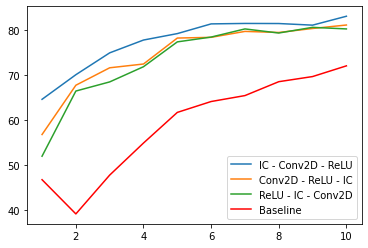

In [ ]:
 # Comparing performance
import matplotlib.pyplot as plt
filename = 'resnet110_epochs_'+str(EPOCHS)+'_bs_'+str(BATCH_SIZE)+'.png'
plt.plot(range(1, EPOCHS+1),test_acc_110_ic1, label="IC - Conv2D - ReLU")
plt.plot(range(1, EPOCHS+1),test_acc_110_ic2, label="Conv2D - ReLU - IC")
plt.plot(range(1, EPOCHS+1),test_acc_110_ic3, label="ReLU - IC - Conv2D")
plt.plot(range(1, EPOCHS+1),test_acc_110, label="Baseline", color="red")
plt.legend()
plt.savefig(filename, dpi=500)
plt.show()

In [ ]:
### Original training loop
'''
train_accuracy_list, test_accuracy_list, train_loss_list = [], [], [] 
for epoch in range(num_epochs):
    running_loss = 0
    for images, labels in train_dataLoader:
        # Flatten 28x28x1 image to 784 vector
        # images = images.view(images.shape[0], -1)
        imgs = images.to(device)
        lbls = labels.to(device)
    
        # Training step
        optimizer.zero_grad()
        out = resnet110(imgs)
        loss = criterion(out, lbls)
        
        #  Check train correct preditions
        # _, train_predicted = torch.max(out.data, 1)
        # train_correct += (train_predicted==labels).sum().item()

        # Backpropagate loss
        loss.backward()
        
        # Optimize weights
        optimizer.step()
        
        running_loss += loss.item()
    
    # print("\nEpoch {} \t Training Time (in minutes) = {}".format(epoch, (time()-start)/60))
    # print("Epoch {} - Training loss: {}".format(epoch, running_loss/len(train_dataLoader)))
    train_loss = running_loss/len(train_dataLoader)
    train_loss_list.append(train_loss)
    train_accuracy = get_accuracy(resnet110, train_dataLoader)
    # print(train_accuracy)
    # print("Epoch {} - Training accuracy: {}".format(epoch, train_accuracy))
    # print("Epoch {} - Training accuracy - Alt: {}".format(epoch, train_model(network)))
    train_accuracy_list.append(train_accuracy)
    test_accuracy = get_accuracy(resnet110, test_dataLoader)
    # print("Epoch {} - Test accuracy: {}".format(epoch, test_accuracy))
    test_accuracy_list.append(test_accuracy)
    print("Epoch: {} \t Training loss: {} \t Training accuracy: {} \t Test accuracy: {}".format(epoch, train_loss, train_accuracy, test_accuracy))
  '''

Epoch: 0 	 Training loss: 2.0450409602021318 	 Training accuracy: 29.14 	 Test accuracy: 29.799999999999997
Epoch: 1 	 Training loss: 5.49911764088799 	 Training accuracy: 10.0 	 Test accuracy: 10.0
Epoch: 2 	 Training loss: 2.3032108030050917 	 Training accuracy: 10.0 	 Test accuracy: 10.0
Epoch: 3 	 Training loss: 2.303347162578417 	 Training accuracy: 10.0 	 Test accuracy: 10.0
Epoch: 4 	 Training loss: 2.303161963172581 	 Training accuracy: 10.0 	 Test accuracy: 10.0


KeyboardInterrupt: ignored